Please adhere to a clear and repeatable folder structure. All file location assumptions in `uavgeo` are based on the following structure:

```
- data/
    - rgb/
        - sfm/
            - dem.tif
            - dtm.tif
            - ortho.tif
            - etc.tif
        - raw/
            - 0001.jpg
            - 0002.jpg
        - other/
            - path.geojson
            - etc.shp 
    - ms/
        - sfm/ 
            - dem.tif
            - dtm.tif
            - ortho.tif
            - etc.
        - raw/
            - 0001.jpg
            - 0002.jpg
        - other/
            - path.geojson
            - etc.shp
```

When working with training the yolov8 model using the `ultralytics` library, the structure is assumed to be the following:
```
- data/
    - yolov8/
        - train
            - images
                - 00001.jpg
                - 00002.jpg
            - labels
                - 00001.txt
                - 00002.txt 
        - test
            - images
                - 00001.jpg
                - 00002.jpg 
            - labels
                - 00001.txt
                - 00002.txt 
        - val
            - images
                - 00001.jpg
                - 00002.jpg 
            - labels
                - 00001.txt
                - 00002.txt 
        - model
            - yolo_best.pth
            - config.yaml
```
Keep this in mind as you make use of various import and export functions in `uavgeo`.


In [ ]:
#using the data download function:
import uavgeo as ug

#downloads by default into relative path from notebook to: "data"
file = ug.load.download("https://zenodo.org/record/8123870/files/ORTHOMOSAIC_230421.jpg", filename = "rgb_ortho.jpg", redownload=True)


# Adhering to the above file structure:
file = ug.load.download("https://zenodo.org/record/8123870/files/ORTHOMOSAIC_230421.jpg", output_dir = "data/rgb/sfm" filename = "ortho.jpg", redownload=True)


In [1]:
#importing sfm result files
import uavgeo as ug
ortho = ug.load.load_sfm(path_to_file = "data/ms/sfm/ortho.tif", xr_name = "ms_ortho")
dem = ug.load.load_sfm(path_to_file = "data/ms/sfm/dem.tif", xr_name = "dem")
dtm = ug.load.load_sfm(path_to_file = "data/ms/sfm/dtm.tif", xr_name = "dtm")


In [1]:
#Sensors based 
def band_selector(device:str):

    implemented = ["micasense-altum-pt", 
                   "dji-multi3",
                   "micasense-rededge-p", 
                   "tetracam-mca6",
                   "parrot-sequoia", 
                   "slantrange-4p",
                   "slantrange-3p" ]

    if device == "micasense-altum-pt": 

        bands = {"blue":{475:32},"green":{560:27}, "red":{668:14}, "rededge":{717:12}, "nir":{842:57}}

    elif device == "dji-multi3":

        bands = {"green":{560:16}, "red":{650:16}, "rededge":{730:16}, "nir":{860:26}}
    
    elif device == "micasense-rededge-p":

        bands = {"blue":{475:32},"green":{560:27}, "red":{668:14}, "rededge":{717:12}, "nir":{842:57}}
    
    elif device == "tetracam-mca6":

        bands = {"blue":{490:10}, "green":{550:10}, "red":{680:10}, "rededge":{720:20}, "nir1":{800:20},"nir2":{900:20}}
    
    elif device == "parrot-sequoia":

        bands = {"green":{550:40}, "red":{660:40}, "rededge":{735:10}, "nir":{790:40}}

    elif device == "slantrange-4p":

        bands = {"blue_rgb": {470:120}, "green_rgb":{550:100}, "red_rgb":{620:110}, "red":{650:40}, "rededge":{710:20}, "nir":{850:100}}

    elif device =="slantrange-3p":

        bands = {"green":{550:40}, "red":{650:40}, "rededge":{710:20}, "nir": {850:100}}

    else:
        raise NotImplementedError("{} is not yet implemented. Please select from: {}".format(device, implemented))

    return bands

def geo_bands_to_colour(bands):
    l = list(bands)
    d= {}

    for item in l:
        for key in bands[item]:
            d[key]=bands[item][key]
            
    return d

In [14]:
import numpy as np

def sum(a, b):
    return a + b

def zipper(a, b, f):
    return np.array([f(ai, bi) for ai, bi in zip(a, b)])

def mapConst(arr, c, f):
    return np.array([f(ai, c) for i, ai in enumerate(arr)])

def dotSS(a, b):
    return a * b

dotVS = lambda v, s: mapConst(v, s, dotSS)

def dotVV(a, b):
    return np.sum(zipper(a, b, dotSS))

def dotMV(A, v):
    return mapConst(A, v, dotVV)

adj = lambda C: 12.92 * C if C < 0.0031308 else 1.055 * pow(C, 0.41666) - 0.055

labF = lambda t: pow(t, 1.0/3.0) if t > 0.00885645 else 0.137931 + 7.787 * t

invLabF = lambda t: t*t*t if t > 0.2069 else 0.12842 * (t - 0.137931)

def XYZ_to_Lab(XYZ):
    lfY = labF(XYZ[1])
    return np.array([(116.0 * lfY - 16)/100,
                     5 * (labF(XYZ[0]) - lfY),
                     2 * (lfY - labF(XYZ[2]))])

def Lab_to_XYZ(Lab):
    YL = (100 * Lab[0] + 16) / 116
    return np.array([invLabF(YL + Lab[1] / 5.0),
                     invLabF(YL),
                     invLabF(YL - Lab[2] / 2.0)])

def XYZ_to_sRGBlin(xyz):
    T = np.array([[3.240, -1.537, -0.499],
                  [-0.969, 1.876, 0.042],
                  [0.056, -0.204, 1.057]])
    return dotMV(T, xyz)

XYZ_to_sRGB = lambda xyz: np.array(list(map(adj, XYZ_to_sRGBlin(xyz))))

def Lab_to_sRGB(Lab):
    return XYZ_to_sRGB(Lab_to_XYZ(Lab))

def getSolarIrr():
    return [B02,B03, B04]

def S2_to_XYZ(rad, T, gain):
    return dotVS(dotMV(T, rad), gain)

def ProperGamma_S2_to_sRGB(rad,gg,gamma,gL):

    T = np.array([[0.268, 0.361, 0.371],
              [0.240, 0.587, 0.174],
              [1.463, -0.427, -0.043]])

    XYZ = S2_to_XYZ(rad, T, gg)
    Lab = XYZ_to_Lab(XYZ)
    L = np.power(gL * Lab[0], gamma)
    return Lab_to_sRGB([L, Lab[1], Lab[2]])


B02 = 0.5  # Replace with actual value
B03 = 0.6  # Replace with actual value
B04 = 0.7  # Replace with actual value






In [2]:
def scale_to_uint8(arr):
    arr = (arr// 256).astype(np.uint8)
    return arr

def scale_to_01(arr):
    arr = arr.astype(np.float16)/255
    return arr

In [5]:
import rioxarray as rx
import numpy as np
xr_name = "ms_ortho"

path_to_file = "data/rgb/sfm/ortho.tif"

ortho = rx.open_rasterio(path_to_file, default_name = xr_name)


In [ ]:
ortho.plot.imshow()

In [4]:
rgb = ortho.sel(band = [1,2,3]).astype(np.uint16)
#rgb = scale_to_uint8(rgb)
rgb = rgb.where(rgb!=0)
rgb = rgb.where(rgb!=65535)
r = rgb.sel(band=1)
g = rgb.sel(band=2)
b = rgb.sel(band=3)

In [6]:
import zen3geo
import uavgeo as ug
dp_ortho = ug.datapipes.start_pipe(iterable = [ortho])
dp_ortho = dp_ortho.slice_with_xbatcher(input_dims = {"x":1024, "y":1024})


In [7]:
raster = list(dp_ortho)[165]

In [8]:
rgb = raster.sel(band = [1,2,3])
rgb = scale_to_01(rgb)

In [9]:
reshaped = rgb.values.reshape(-1,3)

In [37]:
gg = 1.9
gamma = 2.2
gL = 1
import time
# Get the start time
start_time = time.time()

result = np.apply_along_axis(ProperGamma_S2_to_sRGB, axis = 1, arr = reshaped, gg=gg,gamma=gamma,gL=gL)
# Measure the runtime using %timeit
# Get the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime} seconds")

C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:121: RuntimeWarning: invalid value encountered in power
  return pow(t, 1.0/3.0)
C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:108: RuntimeWarning: invalid value encountered in power
  return 1.055 * pow(C, 0.41666) - 0.055
C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:243: RuntimeWarning: invalid value encountered in power
  L = np.power(gL * Lab[0], gamma)


Runtime: 577.52978682518 seconds


In [ ]:
result_unshaped = result.reshape(rgb.shape)

In [ ]:
import xarray as xr
new_xr = xr.DataArray(result_unshaped, coords=rgb.coords, attrs=rgb.attrs)

In [ ]:
new_xr.plot.imshow()

In [3]:
#calculating ndvi and ndwi:
import uavgeo as ug

ndvi = ug.compute.calc_ndvi(bandstack = ortho,red_id = 2, nir_id=3, rescale=False)
ndwi = ug.compute.calc_ndwi(bandstack = ortho, green_id = 1, nir_id=3, rescale=False )


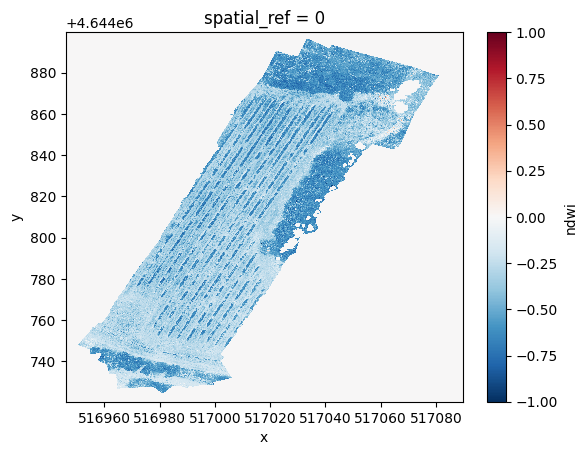

In [4]:
ndwi.plot.imshow()

In [ ]:
#calculating ndvi and ndwi:
import uavgeo as ug

dp_ortho = ug.load.start_pipe(iterable = [ortho])
dp_ortho = dp_ortho_read_from_rioxarray()
dp_ortho = dp_ortho_slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})


In [1]:
# import image and label annotations from YOLO folder:
import zen3geo
import torchdata
import uavgeo as ug
import pandas as pd

labs, imgs = ug.load.load_yolo_folder(yolo_path = "data/yolov8", subset = "test", img_ext = ".png")

dp_img = ug.datapipes.start_pipe(iterable = imgs)
dp_img = dp_img.read_from_rioxarray()
#dp_img = dp_img.slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

dp_labs = ug.datapipes.start_pipe(iterable = labs)
dp_labs = dp_labs.open_files(mode = "rt")
dp_labs = dp_labs.parse_csv(delimiter = " ",return_path = True)
#convert simple text stream to pandas df
dp_labs = dp_labs.parse_yolo()
#Sanity check:
print(len(list(dp_labs)), len(list(dp_img)))
#zip images together labels (IMAGES FIRST, LABELS SECOND)

#in yolo you need images with the labels to calculate the real bounding box
dp_imgs_labs = dp_labs.yolobox_to_gpd(image_datapipe = dp_img)

#clip the images and labels based on input dims and input overlap
dp_clipped = dp_imgs_labs.chip_image_and_label(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

2 2


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [4]:

#clip the images and labels based on input dims and input overlap
dp_save = dp_clipped.save_image_and_label(output_path = "data/yolov8/test2", skip_empty = True, img_out = ".jpg")
list(dp_save)

C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: Not

[(<xarray.DataArray (band: 3, y: 512, x: 512)>
  array([[[159, 199, 202, ..., 210, 214, 193],
          [175, 201, 200, ..., 153, 195, 205],
          [211, 200, 143, ..., 119, 170, 206],
          ...,
          [149, 131, 120, ..., 123, 124, 123],
          [126, 137, 138, ..., 126, 125, 125],
          [165, 174, 155, ..., 128, 126, 125]],
  
         [[145, 185, 190, ..., 201, 205, 184],
          [161, 187, 188, ..., 144, 186, 196],
          [199, 188, 131, ..., 107, 158, 194],
          ...,
          [176, 158, 148, ..., 175, 176, 175],
          [156, 167, 168, ..., 178, 177, 177],
          [195, 204, 185, ..., 180, 178, 177]],
  
         [[125, 165, 168, ..., 180, 184, 163],
          [141, 167, 166, ..., 123, 165, 175],
          [179, 168, 109, ...,  87, 138, 174],
          ...,
          [120, 102,  87, ...,  84,  87,  86],
          [ 95, 106,  98, ...,  87,  86,  86],
          [134, 143, 115, ...,  89,  87,  86]]], dtype=uint8)
  Coordinates:
    * band         (band

In [37]:
l = list(dp_imgs_labs)[1]
raster = l[0]
tdf = l[1]


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [2]:
l = list(dp_clipped)[46]
raster = l[0]
tdf = l[1]

C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

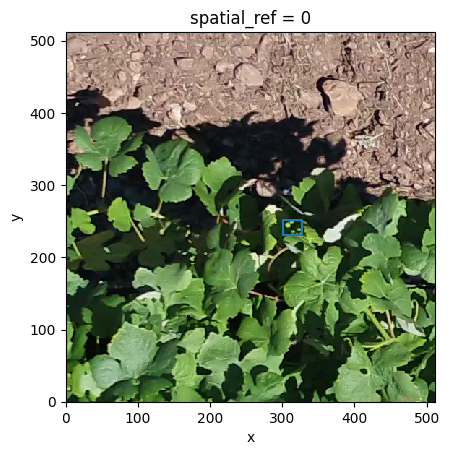

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

raster.plot.imshow(ax=ax)
tdf.boundary.plot(ax=ax)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

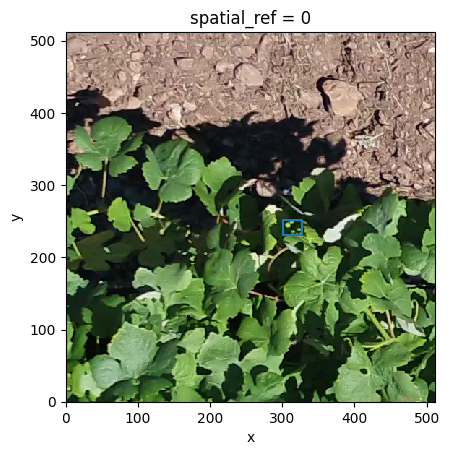

In [47]:
## AFFINE TRANSFORMATION TIME! BOOOOOOOoooooooooohoooooo
# Convert to 0-512 coordinates for every images and every label.
# something with .transform values to figure out!
tf = raster.rio.transform()

tdf.geometry = tdf.translate(xoff = -1 * tf.xoff, yoff = -1 * tf.yoff)
r = raster.assign_coords(x= (raster.x+tf.xoff*-1), y= (raster.y+tf.yoff*-1))


import matplotlib.pyplot as plt
fig, ax = plt.subplots()

r.plot.imshow(ax=ax)
tdf.boundary.plot(ax=ax)


In [7]:
import uavgeo as ug
from ultralytics import YOLO
import uavgeo as ug
import os

# Specify the folder path and output YAML file path
local_working = os.getcwd()
folder_path = 'data/yolov8'
output_file = 'yolo.yaml'

# Generate the YOLO YAML file
f = ug.load.generate_yolo_yaml(local_working, folder_path, output_file, {0: "other",
                                                                         1: "grapes"})


#training is not particularly difficult when the data is well-preprocessed.
model = YOLO("yolov8n.pt")

model.train(data = "yolo.yaml", epochs = 100, imgsz=512, save_period = 5)

New https://pypi.org/project/ultralytics/8.0.137 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.124  Python-3.10.12 torch-2.0.1+cpu CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo.yaml, epochs=100, patience=50, batch=16, imgsz=512, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torc

KeyboardInterrupt: 

In [82]:
# However we want to of course run the model on new batches:
# This is where the torch pipelines return!
# for example, to run on an RGB orthomosaic:
import rioxarray as rx
import numpy as np
import uavgeo as ug
from ultralytics import YOLO
import zen3geo

xr_name = "rgb_ortho"
path_to_file = "data/rgb/sfm/ortho.tif"

#open as a rioxarray
ortho = rx.open_rasterio(path_to_file, default_name = xr_name)
#explore the ortho and make sure it only has 3 bands: r g and b
ortho = ortho.sel(band=[1,2,3])
#make sure its an iterable: in a list or whatever
ortho_dp = ug.datapipes.start_pipe([ortho]) 
# a single ortho is way too big to predict on: so we chip it using the xbatcher from zen3geo
ortho_dp_chipped = ortho_dp.slice_with_xbatcher(input_dims = {"x":512, "y":512})
model = YOLO("yolov8n.pt")


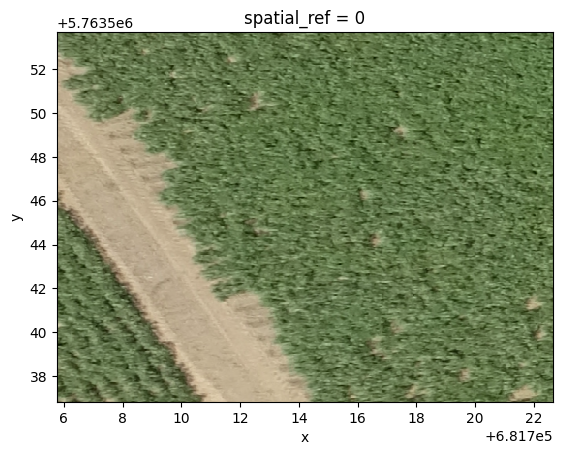

In [2]:
single_r = list(ortho_dp_chipped)[45]
single_r.plot.imshow()

Already downloaded file, please add redownload=True to redownload


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


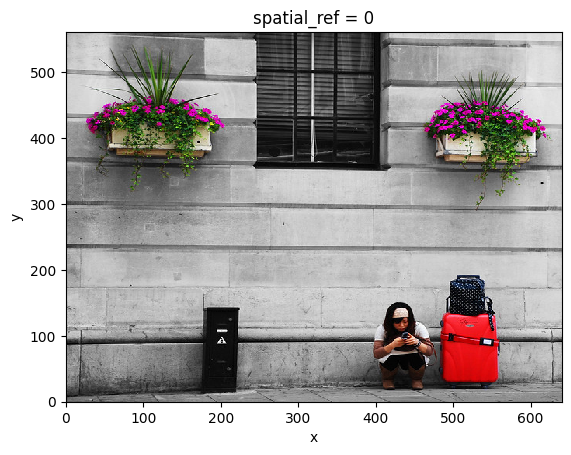

In [1]:

import rioxarray as rx
import numpy as np
import uavgeo as ug
from ultralytics import YOLO
import zen3geo

coco_url = "https://farm4.staticflickr.com/3146/2828991640_d4a07dae4c_z.jpg"
fpath = ug.load.download(coco_url, filename = "coco_test.jpg")
raster = rx.open_rasterio(fpath)

#weird stuff happens with basic image rasters: in this case the y is flipped
#lets unflip that first
raster["y"] = raster["y"][::-1]

raster.plot.imshow()

In [54]:

#make sure its an iterable: in a list or whatever
coco_dp = ug.datapipes.start_pipe([raster]) 
# a single ortho is way too big to predict on: so we chip it using the xbatcher from zen3geo
coco_dp_chipped = coco_dp.slice_with_xbatcher(input_dims = {"x":256, "y":256},input_overlap = {"x":128, "y":128})

model = YOLO("yolov8n.pt")

coco_predicted = coco_dp.predict_yolo(model,tf_required=True)

In [55]:
r = list(coco_dp)
dfs = list(coco_predicted)


0: 576x640 1 person, 2 suitcases, 2 potted plants, 199.2ms
Speed: 6.6ms preprocess, 199.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 640)


In [56]:
i= 0

r0 = r[i]
df = dfs[i]

In [14]:
from shapely import box

geom = [box(xmin =x1,ymin=y1 , xmax=x2,ymax=y2) for x1,y1,x2,y2 in zip(df["xmin"], df["ymin"], df["xmax"], df["ymax"])]
df = df.set_geometry(geom)

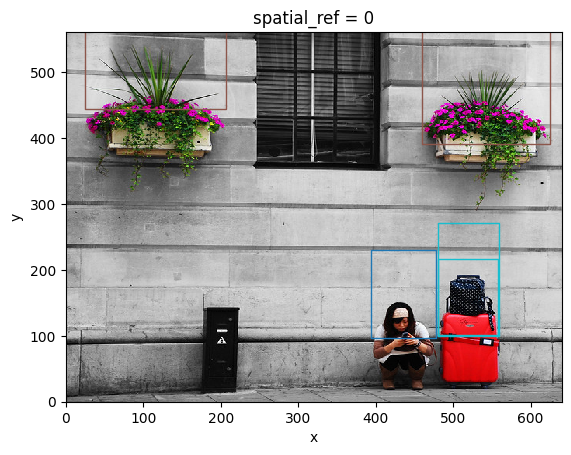

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.plot(ax=ax, column= "class_names",facecolor ="none")
r0.plot.imshow(ax=ax)
#xr.DataArray(reshaped).plot.imshow(ax=ax)

In [58]:
r0.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 560.0)

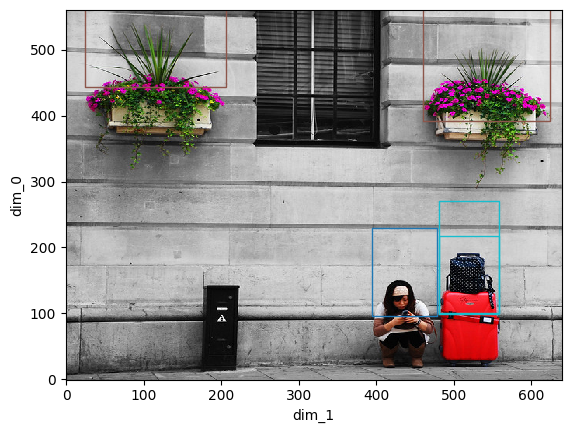

In [59]:
import xarray as xr
reshaped = np.transpose(r0.values, (1,2,0))[::-1]
r_reshaped = xr.DataArray(reshaped)

fig, ax = plt.subplots()
df.plot(ax=ax, column= "class_names",facecolor ="none")
r_reshaped.plot.imshow(ax=ax)


In [29]:
import geopandas as gpd
import pandas as pd
rdf = gpd.GeoDataFrame( pd.concat( dfs, ignore_index=True) )

In [60]:
r0.x

<xarray.DataArray 'x' (x: 640)>
array([5.000e-01, 1.500e+00, 2.500e+00, ..., 6.375e+02, 6.385e+02, 6.395e+02])
Coordinates:
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 636.5 637.5 638.5 639.5
    spatial_ref  int32 0

# The struggle is real: 
Perhaps it is best to make everything work on a single real dataset first: then adapt it for another one later down the line
It already works nicely on a normal image: as in, no coordinate reference BS.

The question is? 
How deep should the focus on orthos etc. be for now? Doesnt that depend on the dataset and next steps for me?

Lets work on inference-side for now, such as a fast-sam implementation for RGB Orthomosaics? (w/crs)
And a fast-sam implementation for RGB images? (w.o/crs)

## The image is shown upside down due to xarray loading
## The image is predicted correctly however: so the coordinates are also upside down


How about a reimplementation of the chipping function:
This works best for GCPed/Ortho/actual CRS imagery

1. define a grid using shapely boxes inside a gdf # DONE
2. chip the original image based on this main gdf # DONE
3. pass the chips through a model of sorts
4. translate the chip-result-coords back to the original grid from 1. raster-coordinate-dfs
5. is the y-axis flipped again?
6. pd.concat the raster-coordinate-dfs `rdf = gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True), crs=dataframesList[0].crs)`. result-df
7. plot the complete image in its CRS with the bbox results in its CRS
   

In [14]:
raster=ortho
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt

In [15]:
# 1. define a gdf grid using shapely boxes, based on input_dims, input_overlap and original raster shape

from shapely import box

def create_chip_bounds_gdf(input_dims, shape_x, shape_y, input_overlap=None, crs = None):
    

    if input_overlap is None:
        input_stepover = input_dims
    
    else: 
        input_stepover = { key: input_dims[key]-input_overlap[key] for key in input_dims}
        
    maxy = ((shape_y-input_dims["y"])//input_stepover["y"]) + 1
    maxx = ((shape_x-input_dims["x"]) //input_stepover["x"]) + 1

    start_x = 0
    start_y = 0
    end_x = input_dims["x"]
    end_y = input_dims["y"]
    
    geom = []
    
    z = []
    k=0
    for i in range(maxy):    
        for j in range(maxx):
            geom.append(box(start_x,start_y,end_x, end_y))

            z.append(k)
            start_x+=input_stepover["x"]
            end_x+=input_stepover["x"]
            k+=1
    
        start_x = 0
        end_x = input_dims["x"]    
        start_y+=input_stepover["y"]
        end_y+=input_stepover["y"]
        
    return gpd.GeoDataFrame({"box_id":z}, geometry = geom,crs=crs)

In [16]:

input_dims  = {"x":1024, "y":1024}
input_overlap = {"x":64, "y":64}

gdf = create_chip_bounds_gdf(input_dims = input_dims, shape_x= ortho.shape[2], shape_y=ortho.shape[1], crs = ortho.rio.crs)


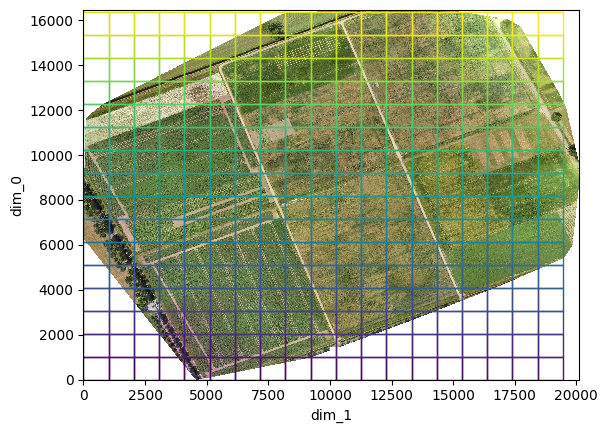

In [20]:
import numpy as np

# it still does not work right:
# as we need to reshape the input AND the reuslt will be in image-reference: see the x-y axis being arbitrary img coords
# and stuff is inverted
reshaped = np.transpose(ortho.values, (1,2,0))[::-1]
r_reshaped = xr.DataArray(reshaped)

fig, ax = plt.subplots()

gdf.plot(ax=ax,column = "box_id", facecolor ="none")
r_reshaped.plot.imshow(ax=ax)

In [21]:
from shapely import box

def imgref_to_crsref_boxes(raster, gdf):
    #for parsing a complete df
    c_geom = []
    for geom in gdf.geometry:

        xmin, ymin, xmax, ymax = geom.bounds
        
        x = raster.x[int(xmin):int(xmax)]
        y= raster.y[int(ymin):int(ymax)]
        
        c_xmin = float(x[0])
        c_xmax = float(x[-1])
        c_ymin = float(y[0])
        c_ymax = float(y[-1])
        c_bbox = box(c_xmin, c_ymin, c_xmax, c_ymax)
        c_geom.append(c_bbox)
    gdf["c_geom"] = c_geom
    return gdf
    
def imgref_to_crs(raster, row):
    # or for applying to a row (slightly faster)

    
    xmin, ymin, xmax, ymax = row.bounds
    
    x = raster.x[int(xmin):int(xmax)]
    y= raster.y[int(ymin):int(ymax)]
    
    c_xmin = float(x[0])
    c_xmax = float(x[-1])
    c_ymin = float(y[0])
    c_ymax = float(y[-1])
    c_bbox = box(c_xmin, c_ymin, c_xmax, c_ymax)
    return c_bbox

In [22]:
# 1b. Keep track of the CRS and actual coordinates of the objects however!
# currently the chips perfectly overlap IMAGE, not CRS coordinates

gdf["x_geom"] = gdf["geometry"].apply(lambda x: imgref_to_crs(raster,x))


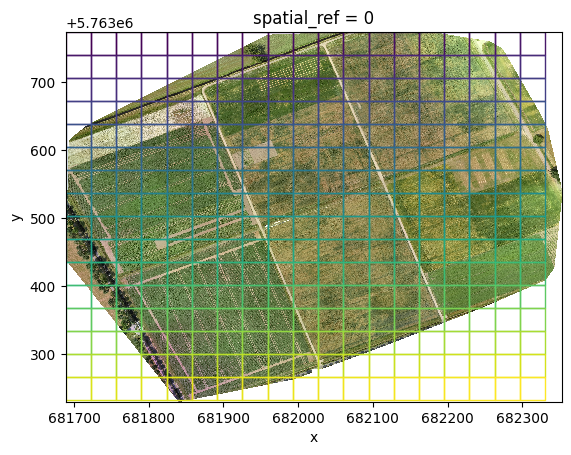

In [23]:
import numpy as np


fig, ax = plt.subplots()

gdf.set_geometry(gdf["x_geom"]).plot(ax=ax,column = "box_id", facecolor ="none")
raster.plot.imshow(ax=ax)

In [35]:
# How to make sure that both image-chips from large image files aka Orthos OR 
# image files from side view/raw from camera or something else can be passed through the same clipping method????
raster = raster.sel(band=[1,2,3])
# probably best to use two different chipping methodologies?

# hacky way to force a crs and clipping method -> set it from the original raster it is based upon: what if the original raster does not have a crs?

x_gdf = gdf.set_geometry(gdf["x_geom"])
row = x_gdf.iloc[121]
#r_reshaped=r_reshaped.rename({"dim_1":"x", "dim_0":"y"})
# Reshaped does not have a crs: it is just the same raster, in a different data format: [rgb,rgb]
r = r_reshaped.assign_coords(x=r_reshaped.x, y = r_reshaped.y, spatial_ref = 0) # make it fit the rio formatting

# write the original crs to this reshaped crs
r = r.rio.write_crs(gdf.crs)

# and run the clipping function:

clipped = raster.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3])

In [66]:
# 3. pass the chips through the model: This is where it could get UGLY HEHEHE
from ultralytics import YOLO, SAM
from ultralytics.models.fastsam import FastSAMPrompt

import numpy as np

In [71]:
model = SAM("sam_b.pt")
clip = np.ascontiguousarray(np.transpose(clipped.values, (1,2,0))[::-1])


In [72]:
DEVICE = "cpu"
sam_result = model(clip, 
                   device=DEVICE,
                  retina_masks =True,
                   imgsz=1024,
                   conf=0.4,
                   iou=0.9)


Ultralytics YOLOv8.0.141  Python-3.10.12 torch-2.0.1+cpu CPU (AMD Ryzen 7 4800HS with Radeon Graphics)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 358438.2ms
Speed: 16.0ms preprocess, 358438.2ms inference, 15.1ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict2


In [161]:
orig = sam_result[0].orig_img
img = xr.DataArray(orig)


In [162]:
# Create an empty xarray DataArray with dimensions (height, width)
da = xr.DataArray(np.zeros_like(img), dims=img.dims)

masks = sam_result[0].masks.data.numpy()

# Loop through the masks and assign unique colors to each mask in the DataArray
for idx, mask in sam_result[0].masks.xy:
    # Generate a unique color for each mask
    color = np.random.randint(0, 256, size=3, dtype=np.uint8)  # You can use any method to generate colors
    
    # Get the x and y segments of the current mask
    y_segments, x_segments = np.where(mask)
    
    # Assign the unique color to the corresponding segments in the DataArray
    da[y_segments, x_segments] = color



type: Unable to allocate 2.72 TiB for an array with shape (997616, 997616, 3) and data type uint8

In [224]:
# Create an empty xarray DataArray with dimensions (height, width)
da = xr.DataArray(np.zeros_like(img), dims=img.dims)

masks = sam_result[0].masks.data.numpy()
mask = masks[0]
da[da["dim_1"]==y[::100]]

type: operands could not be broadcast together with shapes (1024,) (364,) 

In [251]:
da = xr.DataArray(orig[mask]).plot.imshow9)

array([[209, 192, 156],
       [210, 194, 157],
       [209, 191, 156],
       ...,
       [193, 174, 141],
       [191, 172, 139],
       [183, 166, 132]], dtype=uint8)

In [214]:
y,x   = np.where(mask)

In [ ]:
# Visualize the xarray DataArray with the masks represented in different colors
da.plot.imshow()

In [ ]:
# 4. translate the chip-result-coords back to the original grid from 1.

In [ ]:
# 5. is the y-axis flipped again?

In [ ]:
# 6. pd.concat the dataframes per raster/img inthe iterator

In [ ]:
# 7. plot the original raster with the prediction results

In [ ]:
# 8. Implement as torch.datapipes